In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-depression-machine-learning-challenge/sample_submission.csv
/kaggle/input/predicting-depression-machine-learning-challenge/train.csv
/kaggle/input/predicting-depression-machine-learning-challenge/test.csv


In [41]:
train = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/train.csv')
test = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/test.csv')

submission = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/sample_submission.csv')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  # Import train_test_split


#filling missing values on train and test data sets

# Fill categorical missing values with mode
for col in ["Degree", "Financial Stress", "Dietary Habits"]:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(train[col].mode()[0], inplace=True)

# Fill numerical missing values with median
for col in ["Work Pressure", "Job Satisfaction"]:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(train[col].median(), inplace=True)

# Fill 'Profession' categorical missing values with 'Unknown'
train["Profession"].fillna("Unknown", inplace=True)
test["Profession"].fillna("Unknown", inplace=True)



# 3️Drop unnecessary columns (if needed)
train.drop(["Academic Pressure", "CGPA",'Study Satisfaction'], axis=1, inplace=True)
test.drop(["Academic Pressure", "CGPA",'Study Satisfaction'], axis=1, inplace=True)

#encoding the categorical columns
categorical_columns =['Gender','City','Working Professional or Student','Profession','Sleep Duration','Dietary Habits','Degree','Have you ever had suicidal thoughts ?','Family History of Mental Illness']

label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])  
    label_encoders[col] = le  

# Define features and target
X_train = train.drop(columns=["Depression"])  
y_train = train["Depression"]

# For test set, drop only feature columns (since test set doesn’t have target column)
#X_test = test_df.drop(columns=["target"], errors="ignore")  # Ensure it ignores missing target column

# Scale the data (optional but useful for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
test = scaler.transform(test)  # Use transform() only (not fit_transform)

# Define base models
base_models = [
    ("catboost", CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)),
    ("xgboost", XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss")),
    ("lightgbm", LGBMClassifier(n_estimators=100, learning_rate=0.1))
]

# Define meta-model (final model)
meta_model = LogisticRegression()

# Create stacking classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, stack_method="predict_proba")

#  Train the stacked model on the train dataset
stacked_model.fit(X_train, y_train)

#drop id column before the predicting
test = test.drop(columns=["id"], errors="ignore")  # Drop non-feature columns

# Make predictions on the test set
test_predictions = stacked_model.predict(test)

# Save predictions in sample_submission.csv format
submission_new = pd.DataFrame({"id": test["id"], "target": test_predictions})  # Assuming 'id' exists
#submission.to_csv("submission.csv", index=False)

#print("Predictions saved to submission.csv ✅")


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Load datasets
#train = pd.read_csv("train.csv")
#test = pd.read_csv("test.csv")

# Fill missing values
for col in ["Degree", "Financial Stress", "Dietary Habits"]:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(train[col].mode()[0], inplace=True)

for col in ["Work Pressure", "Job Satisfaction"]:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(train[col].median(), inplace=True)

train["Profession"].fillna("Unknown", inplace=True)
test["Profession"].fillna("Unknown", inplace=True)

# Drop unnecessary columns
train.drop(["Academic Pressure", "CGPA", "Study Satisfaction"], axis=1, inplace=True)
test.drop(["Academic Pressure", "CGPA", "Study Satisfaction"], axis=1, inplace=True)

#------------------------------------------------------------------------------------------------------
# Encode categorical columns
categorical_columns = ['Gender', 'Working Professional or Student','Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

#confusing categorical columns
#'City', 'Profession' ,'Sleep Duration' , 'Dietary Habits', 'Degree', 

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])  
    label_encoders[col] = le  


<ipython-input-42-5d141f9138bd>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
<ipython-input-42-5d141f9138bd>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [43]:
#health_status = ['Healthy', 'Unhealthy', 'Moderate', 'More Healthy', 'No Healthy', 'Less Healthy', '5 Healthy', '5 Unhealthy', 'Resistant']
Good_Health=['Healthy','More Healthy', '5 Healthy']
Bad_Health=['Unhealthy','No Healthy','Less Healthy','5 Unhealthy']
Moderate_Health=['Moderate','Resistant']
diet_lifestyle = ['Indoor', 'Electrician', 'MCA', 'Mealy', 'Hormonal', 'Vegas', 'Male', 'Soham', 'Pratham', 'Vivaan', 'Raghav', 'Naina', 'Kolkata']
education_occupation = ['BSc', 'Class 12', 'Academic', 'MCA']
other = ['Gender', 'Yes', 'No Healthy', 'Mealy']

# Function to classify values
def classify(value):
    if value in Good_Health:
        return 'Good_Health'
    elif value in Bad_Health:
        return 'Bad_Health'
    elif value in Moderate_Health:
        return 'Moderate_Health'
    elif value in diet_lifestyle:
        return 'Diet/Lifestyle'
    elif value in education_occupation:
        return 'Education/Occupation'
    elif value in other:
        return 'Other'
    else:
        return 'Uncategorized'

# Apply classification
train['Dietary Habits'] = train['Dietary Habits'].apply(classify)
test['Dietary Habits'] = test['Dietary Habits'].apply(classify)

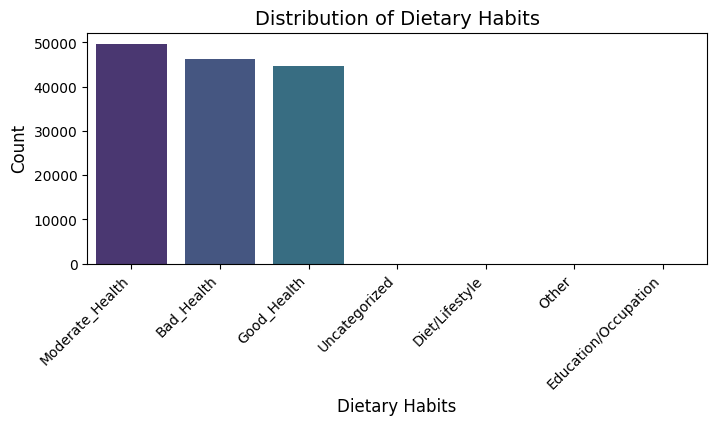

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the values
profession_counts = train['Dietary Habits'].value_counts()

# Plot
plt.figure(figsize=(8, 3))
sns.barplot(x=profession_counts.index, y=profession_counts.values, palette='viridis')

# Labels & Title
plt.xlabel("Dietary Habits", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title("Distribution of Dietary Habits", fontsize=14)

# Show the plot
plt.show()

In [6]:
train["Dietary Habits"].value_counts()

Dietary Habits
Health Status           140681
Uncategorized                8
Diet/Lifestyle               6
Other                        3
Education/Occupation         2
Name: count, dtype: int64

In [44]:
education_map = {
    "High School": ["Class 11", "Class 12"],
    
    "Diploma": [
        "B.Ed", "B.P.Ed", "L.Ed", "LCA", "RCA", "HCA", "N.Pharm", "S.Pharm", 
        "A.Ed", "E.Ed", "I.Ed", "J.Ed", "G.Ed", "K.Ed", "M.B.Ed", "M.M.Ed"
    ],
    
    "Bachelor's": [
        "B.Tech", "BE", "BSc", "B.Sc", "B.Arch", "B.B.Arch", "BBA", "B.Com", "B.Ed", "BCA",
        "B.Pharm", "BPharm", "BPA", "BHM", "B Student", "BArch", "BTech", "B.Com", "B.H", 
        "B.CA", "B.BA", "B.BCA", "B.Press", "B.B.Tech", "B.M.Com", "B.Financial Analyst"
    ],
    
    "Master's": [
        "M.Tech", "M_Tech", "MTech", "ME", "MSc", "MBA", "M.Com", "M.Ed", "MPharm", 
        "M.Pharm", "MPA", "MHM", "M.Arch", "M.S", "M. Business Analyst", "MA", "MCA", 
        "M.UI", "M.", "M.M.Ed"
    ],
    
    "Doctorate": ["PhD", "MD", "MBBS"],
    
    "Law": ["LLB", "LLBA", "LLM", "LL.Com", "LLCom", "LL B.Ed", "LLS", "LLEd"],
    
    "Other": [
        "Plumber", "Entrepreneur", "Working Professional", "Data Scientist", "HR Manager",
        "UX/UI Designer", "Business Analyst", "Doctor", "Mechanical Engineer", "Travel Consultant"
    ]
}

def map_education(value):
    for category, degrees in education_map.items():
        if value in degrees:
            return category
    return "Unknown"

train["Degree"] = train["Degree"].apply(map_education)
test["Degree"] = test["Degree"].apply(map_education)

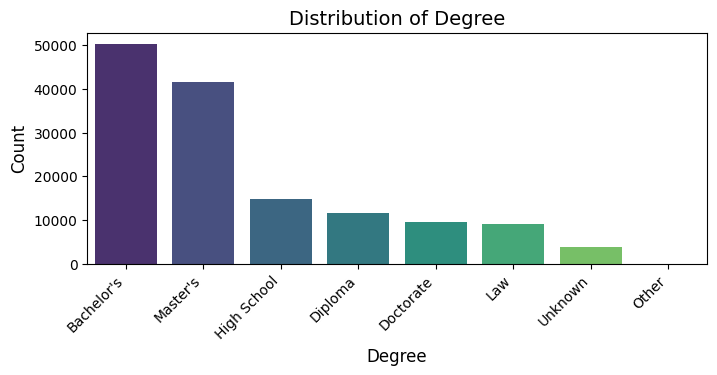

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the values
profession_counts = train['Degree'].value_counts()

# Plot
plt.figure(figsize=(8, 3))
sns.barplot(x=profession_counts.index, y=profession_counts.values, palette='viridis')

# Labels & Title
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title("Distribution of Degree", fontsize=14)

# Show the plot
plt.show()

In [46]:
profession_map = {
    "Education": ["Teacher", "Educational Consultant", "Academic", "B.Ed", "M.Ed"],
    "Healthcare": ["Chemist", "Pharmacist", "Medical Doctor", "Doctor", "Surgeon", "MBBS", "MD", "PhD"],
    "Engineering & Technology": ["Software Engineer", "Mechanical Engineer", "Civil Engineer", "B.Tech", "BE", "BCA", "M.Tech", "ME", "MCA", "M.Pharm"],
    "Business & Finance": ["Financial Analyst", "Investment Banker", "Business Analyst", "Manager", "City Manager", "Entrepreneur", "HR Manager", "Marketing Manager", "Sales Executive", "Consultant", "Digital Marketer"],
    "Law": ["Lawyer", "LLB", "LLBA", "LLM", "LL.Com", "LLCom", "LL B.Ed", "LLS", "LLEd"],
    "Creative & Design": ["Graphic Designer", "Content Writer", "UX/UI Designer", "Architect", "Chef", "Pilot", "Graphic Designer", "Content Writer"],
    "Trades & Services": ["Plumber", "Electrician", "Customer Support", "Travel Consultant"],
    "Research & Analysis": ["Research Analyst", "Analyst", "Researcher", "Data Scientist"],
    "Student & Academic": ["Student", "B.Com", "MBA", "BCA", "MCA", "BBA", "M.Ed"]
    #"Unclassified": ["Unemployed", "No", "Name", "FamilyVirar", "Visakhapatnam", "Yuvraj", "3M", "Manvi", "Samar", "Surat", "Pranav", "Unhealthy"]
}

def map_job(value):
    for category, titles in profession_map.items():
        if value in titles:
            return category
    return "Unknown"

train["Profession"] = train["Profession"].apply(map_job)
test["Profession"] = test["Profession"].apply(map_job)


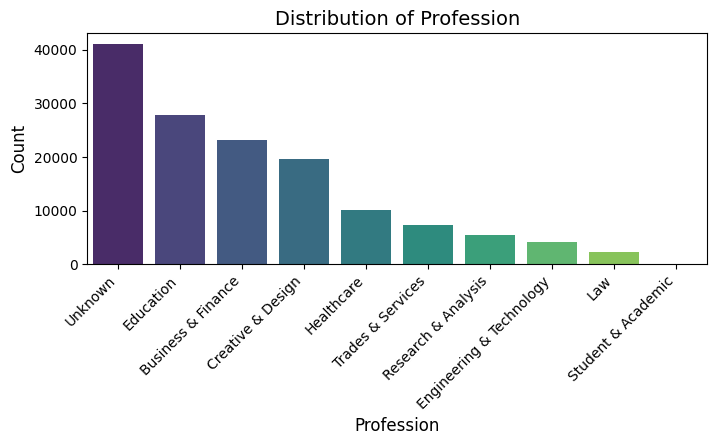

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the values
profession_counts = train['Profession'].value_counts()

# Plot
plt.figure(figsize=(8, 3))
sns.barplot(x=profession_counts.index, y=profession_counts.values, palette='viridis')

# Labels & Title
plt.xlabel("Profession", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title("Distribution of Profession", fontsize=14)

# Show the plot
plt.show()

In [47]:
cities = [
    'Agra', 'Ahmedabad', 'Bangalore', 'Bhopal', 'Chennai', 'Delhi', 'Faridabad', 'Ghaziabad', 'Gurgaon', 'Hyderabad', 'Indore', 'Jaipur', 'Kalyan',
    'Kanpur', 'Kolkata', 'Lucknow', 'Ludhiana', 'Meerut', 'Mumbai', 'Nagpur', 'Nashik', 'Patna', 'Pune', 'Rajkot', 'Srinagar', 'Surat', 'Thane', 
    'Vadodara', 'Varanasi', 'Vasai-Virar', 'Visakhapatnam'
]

def city_map(value):
    if value in cities:
        return value
    return "Unknown"

train["City"] = train["City"].apply(city_map)
test["City"] = test["City"].apply(city_map)


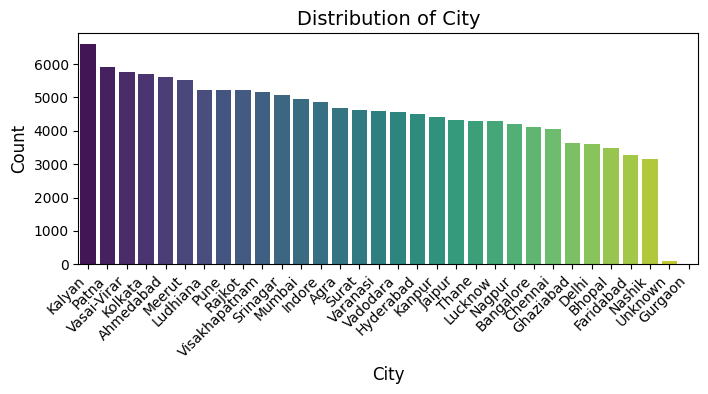

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the values
profession_counts = train['City'].value_counts()

# Plot
plt.figure(figsize=(8, 3))
sns.barplot(x=profession_counts.index, y=profession_counts.values, palette='viridis')

# Labels & Title
plt.xlabel("City", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title("Distribution of City", fontsize=14)

# Show the plot
plt.show()

In [48]:
def categorize(value):
    # Time-related categories
    short_duration = ['Less than 5 hours', '1-2 hours', '1-3 hours', '3-4 hours', '4-5 hours', '4-6 hours', '2-3 hours', '3-6 hours', '6 hours']
    medium_duration = ['6-7 hours', '7-8 hours', '6-8 hours', '8 hours']
    long_duration = ['More than 8 hours', '8-9 hours', '9-5 hours', '9-6 hours', '9-10 hours', '9-11 hours', '10-6 hours', '10-11 hours', 
                     '20-21 hours', '60-65 hours', '50-75 hours', '40-45 hours', '45-48 hours', '55-66 hours', '45 hours', '49 hours']
    
    # Special situations
    special_situations = ['Unhealthy', 'Have_you_ever_had_suicidal_thoughts', 'Work_Study_Hours', 'Sleep_Duration', 'Vivan', 'No']
    
    # Location/Event
    location_event = ['Meerut', 'Pune', 'Indore', '9-5']
    
    # Miscellaneous categories
    ambiguous = ['0', 'than 5 hours', '8-89 hours', 'Galesabad']

    if value in short_duration:
        return 'Short Duration'
    elif value in medium_duration:
        return 'Medium Duration'
    elif value in long_duration:
        return 'Long Duration'
    elif value in special_situations:
        return 'Special Situations'
    elif value in location_event:
        return 'Location/Event'
    elif value in ambiguous:
        return 'Miscellaneous'
    else:
        return 'Unknown'

# Example usage
train['Sleep Duration'] = train['Sleep Duration'].apply(categorize)
test['Sleep Duration'] = test['Sleep Duration'].apply(categorize)


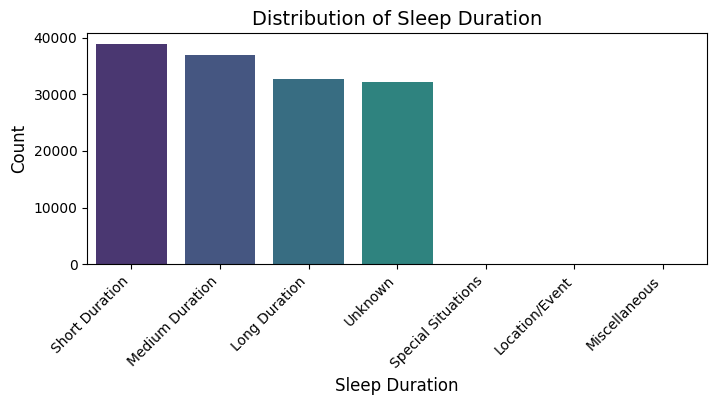

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the values
profession_counts = train['Sleep Duration'].value_counts()

# Plot
plt.figure(figsize=(8, 3))
sns.barplot(x=profession_counts.index, y=profession_counts.values, palette='viridis')

# Labels & Title
plt.xlabel("Sleep Duration", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title("Distribution of Sleep Duration", fontsize=14)

# Show the plot
plt.show()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  int64  
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  int64  
 6   Profession                             140700 non-null  object 
 7   Work Pressure                          140700 non-null  float64
 8   Job Satisfaction                       140700 non-null  float64
 9   Sleep Duration                         140700 non-null  object 
 10  Dietary Habits                         140700 non-null  

# **Encoding Part ?**

* City = label encoding
* Sleep Duration = ordinal Encoding
* Profession = One hot encoding
* degree = One hot encoding
* Dietary Habits = Label Encoding

In [49]:
train["new_col"] = train["Work Pressure"] + train["Job Satisfaction"]

In [14]:
test

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,Shivam,1,53.0,Visakhapatnam,1,Unknown,2.0,5.0,Short Duration,Moderate_Health,Law,0,9.0,3.0,1
1,140701,Sanya,0,58.0,Kolkata,1,Education,2.0,4.0,Short Duration,Moderate_Health,Diploma,0,6.0,4.0,0
2,140702,Yash,1,53.0,Jaipur,1,Education,4.0,1.0,Medium Duration,Moderate_Health,Bachelor's,1,12.0,4.0,0
3,140703,Nalini,0,23.0,Rajkot,0,Unknown,3.0,3.0,Long Duration,Moderate_Health,Bachelor's,1,10.0,4.0,0
4,140704,Shaurya,1,47.0,Kalyan,1,Education,5.0,5.0,Medium Duration,Moderate_Health,Bachelor's,1,3.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93795,234495,Zoya,0,49.0,Jaipur,1,Creative & Design,3.0,5.0,Short Duration,Moderate_Health,Bachelor's,1,2.0,2.0,1
93796,234496,Shlok,1,29.0,Ahmedabad,1,Creative & Design,5.0,1.0,Medium Duration,Moderate_Health,Bachelor's,1,11.0,3.0,1
93797,234497,Rishi,1,24.0,Visakhapatnam,0,Unknown,3.0,3.0,Medium Duration,Moderate_Health,Bachelor's,0,7.0,1.0,0
93798,234498,Eshita,0,23.0,Kalyan,1,Business & Finance,4.0,2.0,Unknown,Good_Health,Unknown,1,7.0,5.0,1


In [50]:
df =  pd.concat([train, test], axis =0)

In [51]:
df["Profession"].value_counts()

Profession
Unknown                     68620
Education                   45980
Business & Finance          38639
Creative & Design           32670
Healthcare                  16944
Trades & Services           12099
Research & Analysis          8911
Engineering & Technology     6905
Law                          3712
Student & Academic             20
Name: count, dtype: int64

In [52]:
df.isnull().sum()

id                                           0
Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                                   0
Work Pressure                                0
Job Satisfaction                             0
Sleep Duration                               0
Dietary Habits                               0
Degree                                       0
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
Depression                               93800
new_col                                  93800
dtype: int64

In [53]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

# ---- 1. Label Encoding for City & Dietary Habits ----
label_encoders = {}
for col in ['City', 'Dietary Habits','Sleep Duration']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for inverse transformation if needed


# ---- 3. One-Hot Encoding for Profession & Degree ----
#df = pd.get_dummies(df, columns=['Profession', 'Degree'], drop_first=True).fillna(0).astype(int)


In [54]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode_and_add(train, column):
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = one_hot_encoder.fit_transform(train[[column]])
    encoded_columns = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out([column]))
    encoded_columns.index = train.index
    train = pd.concat([train, encoded_columns], axis=1)
    train = train.drop(columns=[column])
    return train

columns_to_encode = ['Profession', 'Degree']

for col in columns_to_encode:
    df = one_hot_encode_and_add(df, col)

In [55]:
train = df.dropna(subset=['new_col'])
test = df[df['new_col'].isna()]

test = test.drop(columns=['new_col'])

In [56]:
train = train.drop(columns=['new_col'])

In [57]:
test = test.drop(columns=['Depression'])

In [58]:
train.isnull().sum()

id                                       0
Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Work Pressure                            0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
Profession_Business & Finance            0
Profession_Creative & Design             0
Profession_Education                     0
Profession_Engineering & Technology      0
Profession_Healthcare                    0
Profession_Law                           0
Profession_Research & Analysis           0
Profession_Student & Academic            0
Profession_

In [68]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

X = train.drop(columns=["Depression","Name"])
y = train["Depression"]


In [67]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 32 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  int64  
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  int64  
 5   Working Professional or Student        140700 non-null  int64  
 6   Work Pressure                          140700 non-null  float64
 7   Job Satisfaction                       140700 non-null  float64
 8   Sleep Duration                         140700 non-null  int64  
 9   Dietary Habits                         140700 non-null  int64  
 10  Have you ever had suicidal thoughts ?  140700 non-null  int64

In [69]:
#from sklearn.feature_selection import mutual_info_classif
#import pandas as pd

#X = train.drop(columns=["Depression"])
#y = train["Depression"]

# Compute Mutual Information
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# Convert to DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Info': mi_scores})

# Sort features by importance
mi_df = mi_df.sort_values(by="Mutual_Info", ascending=False)

# Display the top features
print(mi_df)


                                  Feature  Mutual_Info
2                                     Age     0.200331
4         Working Professional or Student     0.137297
22                     Profession_Unknown     0.121573
9   Have you ever had suicidal thoughts ?     0.079426
5                           Work Pressure     0.075055
6                        Job Satisfaction     0.066643
26                     Degree_High School     0.037147
11                       Financial Stress     0.032210
10                       Work/Study Hours     0.023757
8                          Dietary Habits     0.020429
1                                  Gender     0.019001
15                   Profession_Education     0.018984
12       Family History of Mental Illness     0.015585
13          Profession_Business & Finance     0.014512
14           Profession_Creative & Design     0.014037
7                          Sleep Duration     0.010801
28                        Degree_Master's     0.010796
23        

In [78]:
#-----------------------------------------------------------------------------------------------------
# Define features and target
X = train.drop(columns=["Name","Depression","Profession_Law","Degree_Other","id"])
y = train["Depression"]

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test.drop(columns=["Name","Profession_Law","Degree_Other","id"], errors="ignore"))  

# Define base models
base_models = [
    ("catboost", CatBoostClassifier(iterations=100, learning_rate=0.05, depth=6, verbose=0)),
    ("xgboost", XGBClassifier(n_estimators=100, learning_rate=0.05, use_label_encoder=False, eval_metric="logloss")),
    ("lightgbm", LGBMClassifier(n_estimators=100, learning_rate=0.1))
]

# Define meta-model
meta_model = LogisticRegression()

# Create stacking classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, stack_method="predict")

# Train the model
stacked_model.fit(X_train_scaled, y_train)

# Make predictions on validation set
y_val_pred = stacked_model.predict(X_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Model Accuracy on Validation Set: {accuracy:.4f}")  # Print accuracy with 4 decimal places

# Make predictions on test set
test_predictions = stacked_model.predict(X_test_scaled).astype(int)

# Save predictions
submission_new = pd.DataFrame({"id": test["id"], "Depression": test_predictions})
submission_new.to_csv("submission_09.csv", index=False)

print("Predictions saved to submission_09.csv ✅")


[LightGBM] [Info] Number of positive: 20413, number of negative: 92147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181352 -> initscore=-1.507213
[LightGBM] [Info] Start training from score -1.507213
[LightGBM] [Info] Number of positive: 16331, number of negative: 73717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 90048, number of used features: 27
[LightGBM] [Info] [

In [72]:
submission

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0
...,...,...
93795,234495,0
93796,234496,0
93797,234497,0
93798,234498,0


In [73]:
submission_new

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1
